<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#No-Norm-const" data-toc-modified-id="No-Norm-const-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>No Norm const</a></span></li><li><span><a href="#with-Norm-Const" data-toc-modified-id="with-Norm-Const-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>with Norm Const</a></span></li><li><span><a href="#No-Unit-conversion-of-metabolic-Cost" data-toc-modified-id="No-Unit-conversion-of-metabolic-Cost-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>No Unit conversion of metabolic Cost</a></span></li></ul></div>

This book is looking at the effect and need for a normalisation constant of a 1kg individuals gathering at high or low resources.
- No norm Const
- Norm Const 
- Norm Const and no conversion of meta cost units

# Functions

In [1]:
"""
    Contains all functions and classes needed to run the notebooks and
    simulations for my Masters thesis on ontogenetic growth models done as part
    of the "Computational Methods in Ecology and Evolution" MSc at Imperial
    College London 2019/2020
"""


###### Imports ######
from numpy import arange, array
##optimisation
from numpy import unravel_index, argmax, isnan, nan_to_num, zeros, amax, where, zeros_like, around, ravel
from pandas import unique
## maths functions
from scipy.integrate import odeint 
from numpy import exp, sin, pi, log10, log
## plotting
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style="whitegrid")
###### Functions ######


## Supply Model ##
def am(m, dimensionality):
    """
    Calculates mass specific search rate in a functional response as derived in 
    Pawar et al 2012.

    Args:
        m (float): Mass of individual
        dimensionality (str, optional): Dimensionality of the functional 
        response. Defaults to "3D".

    Returns:
        float: Mass specific search rate (a)
    """
    if dimensionality == "3D":
        a0 = 10**-1.77  
        gamma = 1.05 
        return (m**gamma) * a0

    if dimensionality == "2D":
        a0 = 10**-3.08 
        gamma = 0.68 
        return (m**gamma) * a0

def hm(m, dimensionality):
    """
    Calculates mass specific handling time in a functional response as derived
     in Pawar et al 2012 SI. 
    Scaling exponent is 0.75 due to caveats stated in the paper to do with the 
    gathering of data for saturated resources.

    Args:
        m (float): Mass of individual
        dimensionality (str, optional): Dimensionality of the functional response. Defaults to "3D".

    Returns:
        float: Mass specific handling time (h)
    """

    if dimensionality == "3D":
        th0 = 10**3.04  
        beta = 0.75 
        return (m**-beta) * th0

    if dimensionality == "2D":
        th0 = 10**3.95 
        beta = 0.75 
        return (m**-beta) * th0

def Xrt(t, amp, centre, period = 365):
    
    """
    To simulate the fluctuation of resource density in a functional response 
    through time according to a sine wave.

    Args:
        t (int): time passed (is converted to radians in function)
        amp (float): The amplitude of the sin wave as a percentage of centre. 
                    1 = 100% flucuation, i.e. from 0 to 2*centre
        centre (float): The value around which resource density fluctuates.
        period (int): Period of the wave in time. Defaults to 365


    Returns:
        float: Resource density
    """   

    x = t * (2 * pi / period) 

    return (amp*centre * sin(x)) + centre

def Fun_Resp(m, Xr, dimensionality):
    """
    Calculates the functional response of an organism dependent on mass.

    Args:
        m (float): Mass of individual
        ## a0 ([type]): mass dependent search rate 
        R (float): Resource density
        ## h ([type]): [description]
        dimensionality (str): Used to determine how  serach rate and handling rate are calculated. See functions for details.

    Returns:
        [float]: consumption rate of the organism
    """    
    a = am(m, dimensionality)  # find mass dependent search rate
    h = hm(m, dimensionality) # find mass dependent handling time
    
    f = (a *Xr) / (1 + a*h*Xr)
    return f

def Bm (m, delta, proportion, dimensionality):
    """
    Calculated mass specific metabolic cost based on some percentage 
    of effective intake rate i.e. search rate

    Args:
        m (float): Mass of individual
        proportion (float): The proportion of intake rate that will be used
        dimensionality (str): Used to determine how  serach rate and handling rate are calculated. See functions for details.

    Returns:
        [float]: Mass specific metabolic cost
    """    

    if dimensionality == "3D":
        a0 = 10**-1.77  
        delta = 0.75 
        return proportion *  m**delta + a0

    if dimensionality == "2D":
        a0 = 10**-3.08 
        delta = 0.75
        return proportion *  m**delta + a0



def L(t, k = 0.01):
    """
    Suvival Function for reproduction modelled as an exponetially increasing number through time.
    Based on thinking that most organisms will not live long enough for factors 
    such as reproductive senescence to be a factor.

    Args:
        t (int): Time
        k (float, optional): Reproductive senescence. Defaults to 0.01.

    Returns:
        [type]: [description]
    """
    return exp(-k*t)

def reproduction(t, c, m, rho, alpha, k = 0.01):
    """
    Calculates the reproductive output of an organisms at time `t` in terms of biomass

    Args:
        t (int): Time
        c (float): Reproductive scaling constant
        m (float): Mass of individual
        rho (float): Reproductive scaling exponent
        k (float, optional): Reproductive senescence. Defaults to 0.01.]
        
    Returns:
        float: Reproductive output in terms of biomass

    """    
    Z = 2/alpha # instantaneous adult mortality
    Q = L(t-alpha) # juvenile mortality


    return Q * c * (m**rho) * exp(-(k+Z)*(t-alpha))

def metabolic_cost(m, meta_exp=0.751):
    """
    Calculates the metabolic cost of an organism in term of mass/time from Barneche et al 2014.

    Args:
        m (float): Mass of individual (units: mass)
        meta_exp (float): scaling exponent for metabolic cost with mass.Defaults to 0.751 as shown in Peters 1983 book
    Returns:
        float: The "mass cost" of the organism at the given mass
    """

    ## Barneche et al 2014 data
    # alpha = 0.76
    # intercept = exp(-5.71)
    # return intercept * m**alpha

    # peters book data
    B_m= 0.14 * m**(meta_exp) # J/s 
    B_m = B_m *24*60*60 # J/s --> J/d 
    B_m = B_m *2.5*10**-4 # J/d * kg wetmass/J --> wetmass/d

    return B_m

def dmdt(mR0, t, 
         alpha, epsilon, norm_const, meta_prop, meta_exp, 
         c, rho, 
         Xr, amp, period, dimensionality):
    """
    Calculates the instantaneous change in mass at time `t`. 

    Args:
        m (float): Mass of individual
        t (int): time
        alpha (int): maturation time
        epsilon (float): Efficiency term
        norm_const (float) : Normalisation constant, 
                            i.e. Functional response value for a 1kg organism
        meta_prop (float) : Proportion of optimum intake rate that 
                            is assigned to metabolism
        meta_exp (float) : Scaling exponent for metabolism
        c (float): Metabolic cost constant
        rho (float): Metabolic cost exponent
        Xr (float): The expected median value for resource density
        amp (float): amplitude of resource fluctuation around `Xr`, 
                        set to 0 to disable fluctuation
        period (int): the period (duration) of the resource cycle
        dimensionality (str): See `Func_Resp`


    Returns:
        float: change in mass (dm/dt) at time t
    """
    # ensure dimensionality is correct for norm_const
    norm_const = 1#epsilon * Fun_Resp(1, 10**6, dimensionality) *60*60*24

    # check if individual is at/past maturation
    m, R = mR0
    k = 0.01 #  reproductive senesence
    if t < alpha:
        R = 0 # reproductive cost
        repro = 0 # reproductive output
    if t >= alpha:
        R = c * norm_const * (m**rho) # kg/d
        repro = reproduction(t, c*norm_const, m, rho, alpha, k = 0.1)

    # Gain
    Xr_t = Xrt(t, amp, Xr, period)
    gain = epsilon * Fun_Resp(m, Xr, dimensionality) # kg/s
    gain = gain * (60 * 60 * 24)# /s -> /min -> /hour -> /day
    # Loss
    # B_m  = norm_const * meta_prop * m**meta_exp # metabolic as% of consumption
    B_m = metabolic_cost(m, meta_exp) #* norm_const
    loss = B_m + R
    
    dmdt =  gain - loss
    
    # check for shrinking
    if dmdt + m < 0:
        dmdt = -m

        
    return array([dmdt, repro])
    

def dmdt_test(t, mR0,
         alpha, epsilon, norm_const, meta_prop, meta_exp, 
         c, rho, 
         Xr, amp, period, dimensionality):
    """
    Calculates the instantaneous change in mass at time `t`. for use with sol_ivp from scipy

    Args:
        m (float): Mass of individual
        t (int): time
        alpha (int): maturation time
        epsilon (float): Efficiency term
        norm_const (float) : Normalisation constant, 
                            i.e. Functional response value for a 1kg organism
        meta_prop (float) : Proportion of optimum intake rate that 
                            is assigned to metabolism
        meta_exp (float) : Scaling exponent for metabolism
        c (float): Metabolic cost constant
        rho (float): Metabolic cost exponent
        Xr (float): The expected median value for resource density
        amp (float): amplitude of resource fluctuation around `Xr`, 
                        set to 0 to disable fluctuation
        period (int): the period (duration) of the resource cycle
        dimensionality (str): See `Func_Resp`


    Returns:
        float: change in mass (dm/dt) at time t
    """

    # check if individual is at/past maturation
    m, R = mR0
    k = 0.01 #  reproductive senesence
    if t < alpha:
        R = 0 # reproductive cost
        repro = 0 # reproductive output
    if t >= alpha:
        R = c * norm_const * (m**rho) # kg/d
        repro = reproduction(t, c*norm_const, m, rho, alpha, k = 0.1)

    # Gain
    Xr_t = Xrt(t, amp, Xr, period)
    gain = epsilon * Fun_Resp(m, Xr, dimensionality) # kg/s
    gain = gain * (60 * 60 * 24)# /s -> /min -> /hour -> /day
    # Loss
    B_m  = norm_const * meta_prop * m**meta_exp # metabolic as% of consumption
    # B_m = metabolic_cost(m, meta_exp) #* norm_const
    loss = B_m + R
    
    dmdt =  gain - loss
    
    # check for shrinking
    if dmdt + m < 0:
        dmdt = -m

        
    return array([dmdt, repro])
    
def dmdt_integrate(m0, R0, time, params):
    """
    integrates dmdt to return a growth curve.

    Args:
        m0 (float): Initial mass of individual
        R0 (float): Initial reproductive output
        time (int): Time
        params (dict): see `dmdt` function for needed names of parameters

    Returns:
        array: growth curve of organism, and reproductive output of organism
    """    

    # Organise Parameters for integration
    t = arange(0, time, 1)   
    mR0 = array([m0, R0])
    arg = (params["alpha"], params["epsilon"], 
            params["norm_const"], params["meta_prop"], params["meta_exp"], 
            params["c"], params["rho"], 
            params["Xr"], params["amp"], params["period"], 
            params["dimensionality"])

    # Simulate growth
    mR = odeint(func=dmdt, y0=mR0, t=t, args=arg)

    return mR

def plot_supply(m0, R0, time, params):
    """
    Plots the growth curve of a bottom up supply based model in the form:
    dmdt = [gain - loss]m ;  where gain is modeled as a functional response 
    scaled by an efficiency constant and loss is metabolic and reproductive 
    costs.

    Args:
        m0 (float): Initial mass of individual
        R0 (float): Initial reproductive output
        time (int): Time
        params (dict): see `dmdt` function for needed names of parameters

    Returns:
        array: growth curve of organism, and reproductive output of organism
    """

    # Simulate growth
    mR = dmdt_integrate(m0, R0, time, params) 

    # unpack results
    m = mR[:,0]
    repro = mR[:,1]

    t = arange(0, time, 1)

    # plt.figure()
    plt.plot(t, m, label="Mass") #change dimensions from col to row
    plt.plot(t, repro, label="Reproductive Output") 
    plt.xlabel("Time")
    plt.ylabel("Mass")
    plt.legend()
    # plt.show()
    
    return mR
       

## Optimisation


def find_max(arr):
    """
    A function to find the maximum of an array and return its indices

    Arguments:
        arr {np.array} -- the matrix to find the max value of 

    Returns:
        {tuple} --  the indices of the maximum value

    """

    # max_ind = unravel_index(argmax(arr, axis=None), arr.shape)
    max_ind = where(arr == amax(arr))

    return max_ind

def reproduction_array(c_vec, rho_vec, m0, R0, time, params, shrinkage = 0, return_mass=False):
    """[summary]

    Args:
        c_vec ([type]): [description]
        rho_vec ([type]): [description]
        m0 ([type]): [description]
        R0 ([type]): [description]
        time ([type]): [description]
        params (dict): See `dmdt`
        return_mass (bool) : Set true to return array of produced final masses. instead of reproduction.  Defaults to `False`.
        shrinkage (float) : the amount of shrinkage allowed after maturation (alpha). Defaults to 0
    Returns:
        [type]: [description]
    """
    # do the c and rho vectors as a meshgrid 
    # this should speed it up 
    # from there the same as the notebook with all the debugging left to do

    repro_result_array = zeros((len(rho_vec), len(c_vec)))
    mass_result_array = zeros_like(repro_result_array)

    # take some key param vals for neatness
    alpha = params["alpha"]

    for i, rho in enumerate(rho_vec):
        # params["rho"] = rho
        
        for j, c in enumerate(c_vec):
            params["rho"] = rho # need to assign within this loop or it causes assignment issues
            params["c"] = c
            result = dmdt_integrate(m0, R0, time, params)
            mass = result[:,0]
            repro = result[:,1]
            
            if repro[-1] == 0 or isnan(repro[-1]) or repro[alpha] == 0: # to try stop appearance of non-reproducing values/banding
                repro_result_array[i,j] = 0
                mass_result_array[i,j] = 0
            
            elif mass[-1] <= mass[alpha]*(1-shrinkage) or mass[0] > mass[-1] or isnan(mass[-1]) or 0 in mass:
                repro_result_array[i,j] = 0
                mass_result_array[i,j] = 0
                # mass = zeros_like(mass)
                # repro = [0]*time#zeros_like(repro)
            
            else:
                repro_result_array[i,j] = repro[-1]
                mass_result_array[i,j] = mass[-1]

    # if return_mass == True:
    #     # to return mass array in case needed instead of repro
    #     return mass_result_array 
    # else:
    #     return repro_result_array
    return repro_result_array

def find_optimum(c_vec, rho_vec, m0, R0, time, params, shrinkage = 0):
    """[summary]

    Args:
        c_vec ([type]): [description]
        rho_vec ([type]): [description]
        m0 ([type]): [description]
        R0 ([type]): [description]
        time ([type]): [description]
        params ([type]): [description]

    Returns:
        [type]: [description]
    """    

    repro_result_array = reproduction_array(c_vec, rho_vec, m0, 
                                            R0, time, params, shrinkage=shrinkage)
    # find optimum values
    # max_ind = where(repro_result_array == amax(repro_result_array))
    max_ind = find_max(repro_result_array) 
    # max_repro = repro_result_array[max_ind] # unneccessary call
    i, j = max_ind
    c_opt = c_vec[j][0]
    rho_opt = rho_vec[i][0]

    return array([c_opt, rho_opt])

def plot_optimum(c_vec, rho_vec, m0, R0, time, params, shrinkage = 0):
    """[summary]

    Args:
        c_vec ([type]): [description]
        rho_vec ([type]): [description]
        m0 ([type]): [description]
        R0 ([type]): [description]
        time ([type]): [description]
        params ([type]): [description]

    Returns:
        [type]: [description]
    """

    # find resolution of the parameter space scanning
    resolution = c_vec[1] - c_vec[0] 

    #find optimum rho and c values
    repro_array = reproduction_array(c_vec, rho_vec, m0, R0, time, params, shrinkage=shrinkage)
    max_ind = find_max(repro_array)
    i, j = max_ind
    c_opt = c_vec[j]
    rho_opt = rho_vec[i]
    
    #assign optimum rho and c
    params["c"] = c_opt[0] # need to call element for growth curve plot
    params["rho"] = rho_opt[0]

    ## plot the result
    #heatmap
    #tick labels
    c_labels = [i if i in around(arange(0, max(c_vec), 0.1), decimals=1) 
                else None for i in around(c_vec, decimals=2)]
                
    rho_labels = [i if i in around(arange(0, max(rho_vec), 0.2), decimals=1)
                else None for i in around(rho_vec, decimals=2)]

    ax = sb.heatmap(repro_array,
            xticklabels = c_labels, 
            yticklabels= rho_labels, linewidths=0.0,rasterized=True).invert_yaxis() # linewidths and rasterized to stop gridlines whens saved as pdf
    #scale circle for highest value with resolution of heatmap
    offset = resolution *5 
    size = resolution * 2000 #figsize[1] / 6.4
    # circle highest value
    plt.scatter(j+offset, i+offset, s=size, linewidth=3, 
                facecolors='none', edgecolors='c' )
    plt.ylabel("rho")
    plt.xlabel("c")
    plt.title("Reproductive Output (kg)")
    
    # add small plot to top right corner
    # sub = plt.axes([.65, .6, .2, .2], facecolor = "w")
    # plot_supply(m0, R0, time, params)

    # # growth curve
    # plt.subplot(2,1,2)
    # mR =  plot_supply(m0, R0, time, params)
    # mass = mR[:,0]
    # repro = mR[:,1]
    
    return array([c_opt,rho_opt])


###### Classes ######



###### Testing ######
# a section to test functions and other functionality
# trying to see what is causing m to drop to 0 in most cases
# from numpy import linspace

###### Notes / To Do ######


# Parameters

In [2]:
m0 = 1**-3 #1mg#10**-4 #1g
R0 = 0
time = 365*10 #10**6
shrinkage = 0.3
resolution = 0.01
c_vec = around(arange(0, 0.4, resolution), decimals=4)
rho_vec = around(arange(0, 2, resolution), decimals=4)

params = {"alpha" : 365*5, "epsilon" : 0.7,
          "norm_const" : None, "meta_prop" : None, "meta_exp" : 1,
          "c" : 0.1, "rho" : 1, # minimal for minimal effect
          "Xr" : 100, "amp" : 0, "period" : 365, "dimensionality" : None
}


# No Norm const

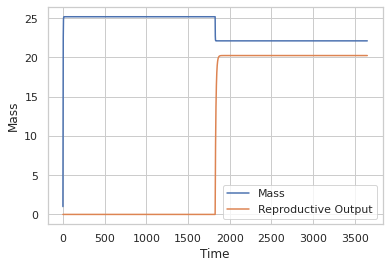

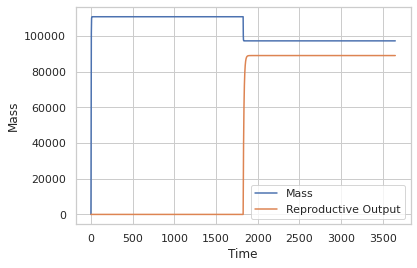

In [3]:
# Changed Functions
def dmdt(mR0, t, 
         alpha, epsilon, norm_const, meta_prop, meta_exp, 
         c, rho, 
         Xr, amp, period, dimensionality):
    """
    Calculates the instantaneous change in mass at time `t`. 

    Args:
        m (float): Mass of individual
        t (int): time
        alpha (int): maturation time
        epsilon (float): Efficiency term
        norm_const (float) : Normalisation constant, 
                            i.e. Functional response value for a 1kg organism
        meta_prop (float) : Proportion of optimum intake rate that 
                            is assigned to metabolism
        meta_exp (float) : Scaling exponent for metabolism
        c (float): Metabolic cost constant
        rho (float): Metabolic cost exponent
        Xr (float): The expected median value for resource density
        amp (float): amplitude of resource fluctuation around `Xr`, 
                        set to 0 to disable fluctuation
        period (int): the period (duration) of the resource cycle
        dimensionality (str): See `Func_Resp`


    Returns:
        float: change in mass (dm/dt) at time t
    """
    # ensure dimensionality is correct for norm_const
    

    # check if individual is at/past maturation
    m, R = mR0
    k = 0.01 #  reproductive senesence
    if t < alpha:
        R = 0 # reproductive cost
        repro = 0 # reproductive output
    if t >= alpha:
        R = c  * (m**rho) # kg/d
        repro = reproduction(t, c, m, rho, alpha, k = 0.1)

    # Gain
    Xr_t = Xrt(t, amp, Xr, period)
    gain = epsilon * Fun_Resp(m, Xr, dimensionality) # kg/s
    gain = gain * (60 * 60 * 24)# /s -> /min -> /hour -> /day
    # Loss
    # B_m  = norm_const * meta_prop * m**meta_exp # metabolic as% of consumption
    B_m = metabolic_cost(m, meta_exp) #* norm_const
    loss = B_m + R
    
    dmdt =  gain - loss
    
    # check for shrinking
    if dmdt + m < 0:
        dmdt = -m

        
    return array([dmdt, repro])
# Main
for dim in ["2D", "3D"]:
    params["dimensionality"] = dim
    fig = plt.figure()
    plot_supply(m0,R0, time, params)



# with Norm Const

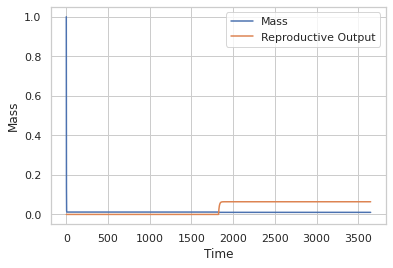

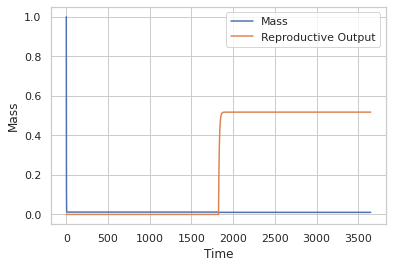

In [4]:
# Changed Functions
def dmdt(mR0, t, 
         alpha, epsilon, norm_const, meta_prop, meta_exp, 
         c, rho, 
         Xr, amp, period, dimensionality):
    """
    Calculates the instantaneous change in mass at time `t`. 

    Args:
        m (float): Mass of individual
        t (int): time
        alpha (int): maturation time
        epsilon (float): Efficiency term
        norm_const (float) : Normalisation constant, 
                            i.e. Functional response value for a 1kg organism
        meta_prop (float) : Proportion of optimum intake rate that 
                            is assigned to metabolism
        meta_exp (float) : Scaling exponent for metabolism
        c (float): Metabolic cost constant
        rho (float): Metabolic cost exponent
        Xr (float): The expected median value for resource density
        amp (float): amplitude of resource fluctuation around `Xr`, 
                        set to 0 to disable fluctuation
        period (int): the period (duration) of the resource cycle
        dimensionality (str): See `Func_Resp`


    Returns:
        float: change in mass (dm/dt) at time t
    """
    # ensure dimensionality is correct for norm_const
    norm_const = epsilon * Fun_Resp(1, 10**6, dimensionality) *60*60*24

    # check if individual is at/past maturation
    m, R = mR0
    k = 0.01 #  reproductive senesence
    if t < alpha:
        R = 0 # reproductive cost
        repro = 0 # reproductive output
    if t >= alpha:
        R = c * norm_const * (m**rho) # kg/d
        repro = reproduction(t, c*norm_const, m, rho, alpha, k = 0.1)

    # Gain
    Xr_t = Xrt(t, amp, Xr, period)
    gain = epsilon * Fun_Resp(m, Xr, dimensionality) # kg/s
    gain = gain * (60 * 60 * 24)# /s -> /min -> /hour -> /day
    # Loss
    # B_m  = norm_const * meta_prop * m**meta_exp # metabolic as% of consumption
    B_m = metabolic_cost(m, meta_exp) * norm_const
    loss = B_m + R
    
    dmdt =  gain - loss
    
    # check for shrinking
    if dmdt + m < 0:
        dmdt = -m

        
    return array([dmdt, repro])
# Main

for dim in ["2D", "3D"]:
    params["dimensionality"] = dim
    fig = plt.figure()
    plot_supply(m0,R0, time, params)


# No Unit conversion of metabolic Cost
- This is not really grounded in reality, more hopefull thinking that something will show through

<ipython-input-1-be1d00978e2a>:46: RuntimeWarning: invalid value encountered in double_scalars
  return (m**gamma) * a0
<ipython-input-1-be1d00978e2a>:71: RuntimeWarning: invalid value encountered in double_scalars
  return (m**-beta) * th0


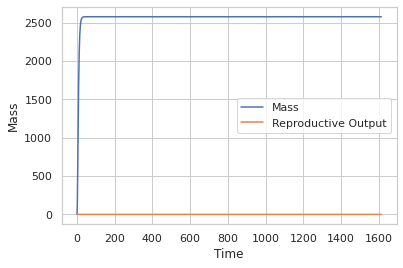

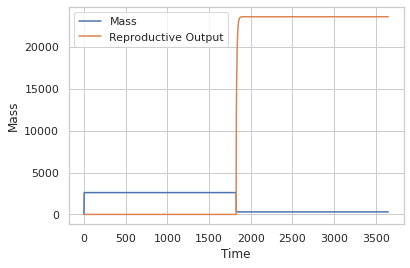

In [5]:
# Changed Functions
def metabolic_cost(m, meta_exp=0.751):
    """
    Calculates the metabolic cost of an organism in term of mass/time from Barneche et al 2014.

    Args:
        m (float): Mass of individual (units: mass)
        meta_exp (float): scaling exponent for metabolic cost with mass.Defaults to 0.751 as shown in Peters 1983 book
    Returns:
        float: The "mass cost" of the organism at the given mass
    """

    ## Barneche et al 2014 data
    # alpha = 0.76
    # intercept = exp(-5.71)
    # return intercept * m**alpha

    # peters book data
    B_m= 0.14 * m**(meta_exp) # J/s 
#     B_m = B_m *24*60*60 # J/s --> J/d 
#     B_m = B_m *2.5*10**-4 # J/d * kg wetmass/J --> wetmass/d

    return B_m


def dmdt(mR0, t, 
         alpha, epsilon, norm_const, meta_prop, meta_exp, 
         c, rho, 
         Xr, amp, period, dimensionality):
    """
    Calculates the instantaneous change in mass at time `t`. 

    Args:
        m (float): Mass of individual
        t (int): time
        alpha (int): maturation time
        epsilon (float): Efficiency term
        norm_const (float) : Normalisation constant, 
                            i.e. Functional response value for a 1kg organism
        meta_prop (float) : Proportion of optimum intake rate that 
                            is assigned to metabolism
        meta_exp (float) : Scaling exponent for metabolism
        c (float): Metabolic cost constant
        rho (float): Metabolic cost exponent
        Xr (float): The expected median value for resource density
        amp (float): amplitude of resource fluctuation around `Xr`, 
                        set to 0 to disable fluctuation
        period (int): the period (duration) of the resource cycle
        dimensionality (str): See `Func_Resp`


    Returns:
        float: change in mass (dm/dt) at time t
    """
    # ensure dimensionality is correct for norm_const
    norm_const = epsilon * Fun_Resp(1, 10**6, dimensionality) *60*60*24

    # check if individual is at/past maturation
    m, R = mR0
    k = 0.01 #  reproductive senesence
    if t < alpha:
        R = 0 # reproductive cost
        repro = 0 # reproductive output
    if t >= alpha:
        R = c * norm_const * (m**rho) # kg/d
        repro = reproduction(t, c*norm_const, m, rho, alpha, k = 0.1)

    # Gain
    Xr_t = Xrt(t, amp, Xr, period)
    gain = epsilon * Fun_Resp(m, Xr, dimensionality) # kg/s
    gain = gain * (60 * 60 * 24)# /s -> /min -> /hour -> /day
    # Loss
    # B_m  = norm_const * meta_prop * m**meta_exp # metabolic as% of consumption
    B_m = metabolic_cost(m, meta_exp) * norm_const
    loss = B_m + R
    
    dmdt =  gain - loss
    
    # check for shrinking
    if dmdt + m < 0:
        dmdt = -m

        
    return array([dmdt, repro])
# Main

for dim in ["2D", "3D"]:
    params["dimensionality"] = dim
    fig = plt.figure()
    plot_supply(m0,R0, time, params)
